In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

df = pd.read_csv('bank-full.csv', delimiter=';')


df.columns = df.columns.str.lower().str.replace(' ', '_')


fields = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 
    'contact', 'day', 'month', 'duration', 'campaign', 
    'pdays', 'previous', 'poutcome', 'y'
]
df = df[fields]

categorical = df.select_dtypes(include=['object']).columns.tolist()
for c in categorical:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df['y'] = (df['y'] == 'yes').astype(int)

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train['y'].values
y_val = df_val['y'].values
del df_train['y']
del df_val['y']

numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
for n in numerical:
    auc = roc_auc_score(y_train, df_train[n])
    if auc < 0.5:
        df_train[n] = -df_train[n]
        auc = roc_auc_score(y_train, df_train[n])
    print(f'Feature: {n}, AUC: {auc:.3f}')



Feature: age, AUC: 0.508
Feature: balance, AUC: 0.587
Feature: day, AUC: 0.525
Feature: duration, AUC: 0.805
Feature: campaign, AUC: 0.570
Feature: pdays, AUC: 0.597
Feature: previous, AUC: 0.606


In [28]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]

auc_val = roc_auc_score(y_val, y_pred)
print(f'AUC on validation set: {auc_val:.3f}')

AUC on validation set: 0.901


In [29]:
import matplotlib.pyplot as plt

In [30]:
scores = []
thresholds = np.arange(0.0, 1.01, 0.01)


for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)  
    predict_negative = (y_pred < t)    

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else float('nan')
    recall = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    
    scores.append((t, tp, fp, fn, tn, precision, recall))

columns = ["thresholds", "tp", "fp", "fn", "tn", "precision", "recall"]
df_scores = pd.DataFrame(scores, columns=columns)

print(df_scores[::10])


     thresholds    tp    fp    fn    tn  precision    recall
0           0.0  1060  7982     0     0   0.117231  1.000000
10          0.1  1000  2834    60  5148   0.260824  0.943396
20          0.2   843  1212   217  6770   0.410219  0.795283
30          0.3   706   695   354  7287   0.503926  0.666038
40          0.4   586   465   474  7517   0.557564  0.552830
50          0.5   498   321   562  7661   0.608059  0.469811
60          0.6   401   214   659  7768   0.652033  0.378302
70          0.7   307   155   753  7827   0.664502  0.289623
80          0.8   201   103   859  7879   0.661184  0.189623
90          0.9   103    54   957  7928   0.656051  0.097170
100         1.0     0     0  1060  7982        NaN  0.000000


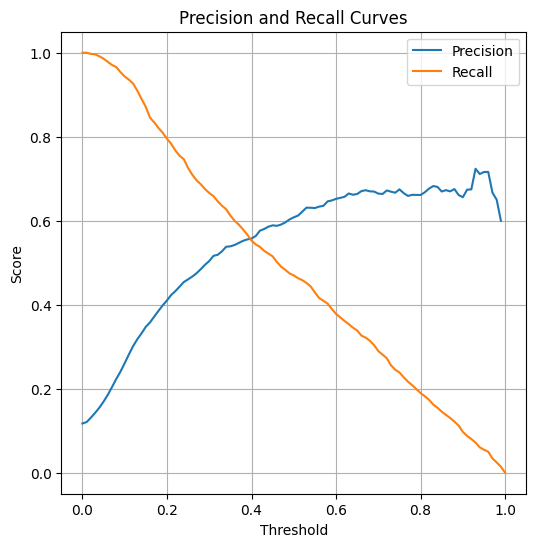

In [31]:
plt.figure(figsize=(6, 6))
plt.plot(thresholds, df_scores['precision'], label='Precision')
plt.plot(thresholds, df_scores['recall'], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves')
plt.legend()
plt.grid()
plt.show()

In [32]:
f1_scores = []
for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
    f1_scores.append(f1)


max_f1_threshold = thresholds[np.argmax(f1_scores)]
print(f'Maximum F1 score occurs at threshold: {max_f1_threshold:.2f}')

Maximum F1 score occurs at threshold: 0.34


In [33]:
from sklearn.model_selection import KFold


In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = []

for train_index, val_index in kf.split(df_full_train):
    df_fold_train = df_full_train.iloc[train_index]
    df_fold_val = df_full_train.iloc[val_index]
    
    y_fold_train = df_fold_train['y'].values
    del df_fold_train['y']
    
    train_dicts = df_fold_train.to_dict(orient='records')
    val_dicts = df_fold_val.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_fold_train = dv.fit_transform(train_dicts)
    X_fold_val = dv.transform(val_dicts)

    model.fit(X_fold_train, y_fold_train)
    y_fold_pred = model.predict_proba(X_fold_val)[:, 1]
    auc_fold = roc_auc_score(df_fold_val['y'].values, y_fold_pred)
    cv_scores.append(auc_fold)

mean_auc = np.mean(cv_scores)
std_auc = np.std(cv_scores)

print(f'Mean AUC across folds: {mean_auc:.3f}, Standard Deviation: {std_auc:.3f}')

Mean AUC across folds: 0.906, Standard Deviation: 0.007


In [35]:
C_values = [0.000001, 0.001, 1]
results = []

for C in C_values:
    cv_scores = []
    for train_index, val_index in kf.split(df_full_train):
        df_fold_train = df_full_train.iloc[train_index]
        df_fold_val = df_full_train.iloc[val_index]

        y_fold_train = df_fold_train['y'].values
        del df_fold_train['y']
        
        train_dicts = df_fold_train.to_dict(orient='records')
        val_dicts = df_fold_val.to_dict(orient='records')

        dv = DictVectorizer(sparse=False)
        X_fold_train = dv.fit_transform(train_dicts)
        X_fold_val = dv.transform(val_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict_proba(X_fold_val)[:, 1]
        auc_fold = roc_auc_score(df_fold_val['y'].values, y_fold_pred)
        cv_scores.append(auc_fold)

    mean_auc = np.mean(cv_scores)
    std_auc = np.std(cv_scores)
    results.append((C, mean_auc, std_auc))

results = sorted(results, key=lambda x: (-x[1], x[2], x[0]))  # Sort by mean AUC, then std, then C
best_C = results[0]
print(f'Best C: {best_C[0]}, Mean AUC: {best_C[1]:.3f}, Standard Deviation: {best_C[2]:.3f}')

Best C: 1, Mean AUC: 0.906, Standard Deviation: 0.007
